# Mulliken analysis tutorial

An introduction to running and interpreting a Mulliken analysis. 

Before starting, it is beneficial to familiarise yourself with graph plotting with `pyplot` - have a look at the tutorial in [`external/pyplot.ipynb`](external/pyplot.ipynb).

The pre-requisite of running a Mulliken analysis is generating the data. The code presented is specifically designed to work the `Mulliken.out` file generated by an `FHI-aims` calculation (*read the manual for how to generate this data file!*).

Once we have the necessary input data, we can start to think about importing the appropriate python functions:

In [1]:
from carmm.analyse.mulliken import parse_mulliken_file

(If you get a `ModuleNotFoundError`, you need probably to refer back to the [`README.md`](README.md) and set the `JUPYTER_PATH` variable to include the `carmm` directory)

We'll need more functions from `carmm` as we progress, but `parse_mulliken_file` allows us to analyse the `Mulliken.out` data thus:

In [2]:
file = "../data/Fe-CO/Mulliken.out"
mulliken_data = parse_mulliken_file(file)

which will take the data file, parse its contents and then return a data object to the variable `mulliken_data`. This data object is of a custom type called `Mulliken`, and essentially just stores all the data in a hierarchical structured manner of:

| Data | Min | Max |
|------|-----|-----|
| Atoms | 1   | `natoms` |
| Spin  | 1   | 2 |
| **k**-points | 1 | `nkpts` |
| states | 1 | `nstates` |

with each state then storing information on whether it is occupied, and what angular momenta contributions there are from the current `atom`/`spin`/`kpt` combination.

Once analysed, the simplest way for us to interrogate the Mulliken data is to get the profile of the entire density of states (DOS) with `get_all_plot_data()`:

In [3]:
x, data = mulliken_data.get_all_plot_data()

which returns an x-axis of energy values around the Fermi energy/level (depending on whether we are dealing with a molecular or periodic system), and the y-axis data which is the "density of states".

<!--TO DO: Insert DOS equation -->

**It is important to be aware that `data` can have one or two dimensions**, depending on whether the system is spin-paired or spin-unpaired. In the paired situation, the only dimension returned is the density of states at each x-axis values; in unpaired case, the first dimension reflects the spin-up and spin-down channels, whilst the second dimension is then the density of states information. 

In the current example, Fe is paramagnetic so there are separate spin channels:

In [4]:
print(len(data))

2


In the simplest case, we can plot all of the density states together using `matplotlib`

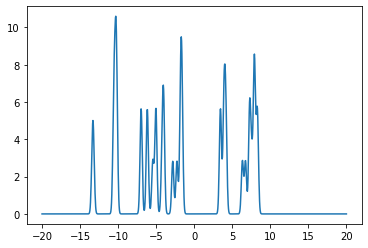

In [5]:
import matplotlib.pyplot as plt
plt.plot(x,data[0]+data[1])
plt.show()

but for spin-unpaired system like this, it is probably more informative to split the spin-up and spin-down components, as given below (note the use of `-data[1]` to reflect the spin-down data to below the zero-line):

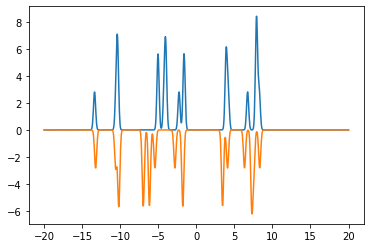

In [6]:
import matplotlib.pyplot as plt
plt.plot(x,data[0])
plt.plot(x,-data[1])
plt.show()

The colours can be subsequently tidied using normal `matplotlib` commands, and so won't be discussed further here, but there is another helpful function avaiable called `set_graph_axes_mulliken` that will tidy the axes and add on the Fermi energy/level:

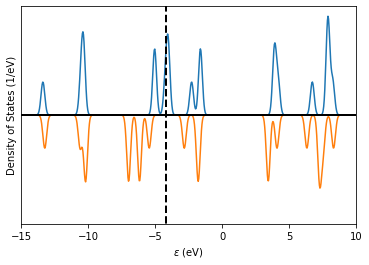

In [7]:
from carmm.analyse.graphs import set_graph_axes_mulliken
plt.plot(x,data[0])
plt.plot(x,-data[1])
set_graph_axes_mulliken(plt, x, data, mulliken_data.get_homo(), mulliken_data.get_graph_xlabel())
plt.show()

Notice here we are passing in some variables we have already created (`plt`, `x`, `data`) as well as information on the HOMO for our system (`mulliken_data.get_homo()`) and also the x-axis label, which depends on whether the system is molecular or periodic (`mulliken_data.get_graph_xlabel()`)

Developing more complicated Mulliken graphs is simply a case of combining specific requests to the `Mulliken` object, with respect to atom indices, spins, and angular momenta, with careful plotting using `matplotlib`. 

As an example, lets analyse just the Fe contributions to the entire DOS outline. For this we need to know the original atomic coordinate structure (as this isn't in the `Mulliken.out` file), which we obtain using functionality from `ASE`, and then find out the atom index for Fe:

In [8]:
# First load atom coordinates
from ase.io import read
file = "../data/Fe-CO/fe-co_light.log"
atoms = read(file)

# Then probe for indices
from carmm.analyse.bonds import get_indices_of_elements
fe_indices = get_indices_of_elements(atoms.get_chemical_symbols(), 'fe')

This automates a process for giving us the indices (index in this particular case!) for the Fe atoms:

In [9]:
print(fe_indices)

[0]


but there is no reason why indices for atoms can be chosen on other reasons, such as ligand grouping or radial distance.

Now we just need to probe the Mulliken object for contributions only associated with this atom index.

In [10]:
x, fe = mulliken_data.get_plot_data(fe_indices, range(mulliken_data.get_nspin()),
                                            range(mulliken_data.get_nkpts()), 'spdf')

This is a little more involved than some previous commands, but with scrutiny you'll see we are requesting Mulliken data for:
- the indices of the Fe atoms (`fe_indices`)
- across all spins possible (`range(mulliken_data.get_nspin())`)
- across all **k**-points possible (`range(mulliken_data.get_nkpts())`)
- and for the angular momenta contributions of `s`, `p`, `d` and `f`

Lets plot this data out against the overall outline we obtained before:

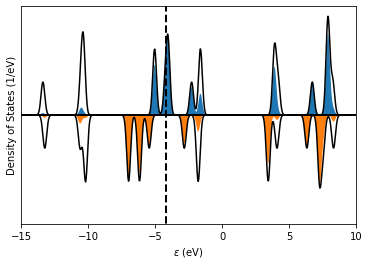

In [11]:
plt.plot(x,data[0],'black')
plt.plot(x,-data[1],'black')

plt.fill_between(x, [0.0 * len(x)], fe[0])
plt.fill_between(x, [0.0 * len(x)], -fe[1])

set_graph_axes_mulliken(plt, x, data, mulliken_data.get_homo(), mulliken_data.get_graph_xlabel())
plt.show()

And now we can see that the states around the Fermi energy are predominantly from the Fe, whilst C and O must contribute to the states below -10 eV and partially at -3 eV. 

Further deconvolution of the contributions can be as simple or as complex as necessary to interrogate and understand the data. Below is a final example where all of the angular contributions for Fe are presented, to give you inspiration going forward.

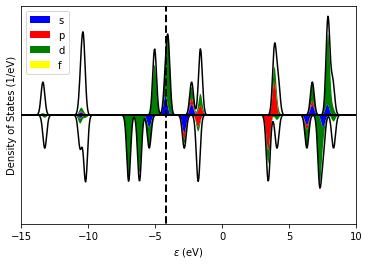

In [14]:
plt.plot(x,data[0],'black')
plt.plot(x,-data[1],'black')

# Dictionary for colours, so we can make the graph look good
alpha = {
    's' : 'blue',
    'p' : 'red',
    'd' : 'green',
    'f' : 'yellow'
}

# Collect the angular contributions and plot each separately
for angular in ['s','p','d','f']:
    x, fe_angular = mulliken_data.get_plot_data(fe_indices,
                                                range(mulliken_data.get_nspin()),
                                                range(mulliken_data.get_nkpts()),
                                                angular)
    
    if angular is 's':
        fe_previous = [ [ 0.0 * len(x) ] for j in range(len(fe_angular)) ]
        
    plt.fill_between(x, fe_previous[0], fe_previous[0]+fe_angular[0],
                        label=angular, facecolor=colors[angular])
    plt.fill_between(x, [-i for i in fe_previous[1]], [-i for i in fe_previous[1]+fe_angular[1]],
                                       facecolor=colors[angular])
    
    for i in range(len(fe_previous)):
        fe_previous[i] += fe_angular[i]

set_graph_axes_mulliken(plt, x, data, mulliken_data.get_homo(), mulliken_data.get_graph_xlabel())
plt.legend()
plt.show()